# Load the data

## Import Libraries

In [1]:
import pandas
import numpy
import sys
from time import time
import logging
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import time
from sklearn import metrics, grid_search
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from operator import itemgetter
from sklearn.svm import SVC
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from __future__ import print_function
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


print(__doc__)
# fix random seed for reproducibility
plt.rcParams['figure.figsize'] = (20, 10)

Automatically created module for IPython interactive environment


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


 ## Load Datasets

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

2017-01-30 00:05:16,380 Loading LFW people faces from /Users/salemameen/scikit_learn_data/lfw_home
2017-01-30 00:05:16,538 Loading face #00001 / 01288
2017-01-30 00:05:20,034 Loading face #01001 / 01288


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


# Prepare the data for classification

In [3]:
# Make developement dataset for genrilization and final testing
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
from sklearn.cross_validation import train_test_split
# Extracting 20% testing data
X_train_feature, X_deploy, y_train_feature, y_deploy = train_test_split(
    X, y, test_size=0.15, random_state=42)
# Make training and validation data sets for building the models and choose the hyperparameters
X_train, X_test, y_train, y_test = train_test_split(
    X_train_feature, y_train_feature, test_size=0.15, random_state=0)


# PCA

In [4]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_deploy = pca.transform(X_deploy)

Extracting the top 150 eigenfaces from 929 faces
Projecting the input data on the eigenfaces orthonormal basis


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


# Building classifiers

Function of printing best three models

In [5]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

## KNN classifier


### Seaching for the best hyperparameters 


In [6]:

from sklearn.neighbors import KNeighborsClassifier
parameters =  {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14], 'algorithm': ['auto','ball_tree','kd_tree','brute']}
knn = KNeighborsClassifier()
clf = grid_search.GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)
report(clf.grid_scores_)

Model with rank: 1
Mean validation score: 0.582 (std: 0.040)
Parameters: {'algorithm': 'auto', 'n_neighbors': 3}

Model with rank: 2
Mean validation score: 0.582 (std: 0.026)
Parameters: {'algorithm': 'auto', 'n_neighbors': 6}

Model with rank: 3
Mean validation score: 0.582 (std: 0.040)
Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 3}



### Classifier

In [7]:
clf_neigh = KNeighborsClassifier(algorithm='auto' , n_neighbors=4)
#Training
start_time = time.time()
clf_neigh.fit(X_train, y_train)
print("The time for training KNN is  %s seconds " % (time.time() - start_time))

# Make a prediction
y_pred = clf_neigh.predict(X_test)

The time for training KNN is  0.0027120113372802734 seconds 


                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.45      0.53        11
     Colin Powell       0.86      0.60      0.71        30
  Donald Rumsfeld       0.36      0.40      0.38        10
    George W Bush       0.70      0.96      0.81        72
Gerhard Schroeder       1.00      0.21      0.35        14
      Hugo Chavez       0.67      0.25      0.36         8
       Tony Blair       0.60      0.60      0.60        20

      avg / total       0.71      0.68      0.66       165

[[ 5  0  1  4  0  0  1]
 [ 1 18  2  6  0  1  2]
 [ 1  1  4  4  0  0  0]
 [ 0  0  1 69  0  0  2]
 [ 0  0  1  7  3  0  3]
 [ 1  1  0  4  0  2  0]
 [ 0  1  2  5  0  0 12]]


ValueError: total size of new array must be unchanged

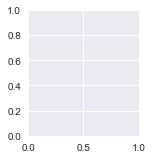

In [9]:
###############################################################################
# Quantitative evaluation of the model quality on the test set



print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## SVM classifier
### Seaching for the best hyperparameters 


In [10]:
from sklearn import svm
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 20]}
parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
report(clf.grid_scores_)

Model with rank: 1
Mean validation score: 0.780 (std: 0.021)
Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.776 (std: 0.009)
Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.776 (std: 0.009)
Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}



In [12]:
clf_svm = SVC(C=10.0, gamma=0.001, kernel='rbf')
#Training
start_time = time.time()
clf_svm.fit(X_train, y_train)
print("The time for training SVM is  %s seconds " % (time.time() - start_time))

# Make a prediction
y_pred = clf_svm.predict(X_test)

print("===================================================================")
print("The accuracy on validation dataset of Linear SVM: \t", metrics.accuracy_score(y_test, y_pred))
print("Precision on validation dataset of Linear SVM:    \t", metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall on validation dataset of Linear SVM :      \t", metrics.recall_score(y_test, y_pred, average="macro"))
print("F1 score on validation dataset of Linear SVM:     \t", metrics.f1_score(y_test, y_pred, average="macro"))
print("===================================================================")
print(metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2','3','4', '5', '6', '7']))

The time for training SVM is  0.1848909854888916 seconds 
The accuracy on validation dataset of Linear SVM: 	 0.848484848485
Precision on validation dataset of Linear SVM:    	 0.836025878883
Recall on validation dataset of Linear SVM :      	 0.78944547516
F1 score on validation dataset of Linear SVM:     	 0.804936300512
             precision    recall  f1-score   support

          0       1.00      0.82      0.90        11
          1       0.87      0.87      0.87        30
          2       0.62      0.80      0.70        10
          3       0.87      0.93      0.90        72
          4       0.73      0.79      0.76        14
          5       0.83      0.62      0.71         8
          6       0.93      0.70      0.80        20

avg / total       0.86      0.85      0.85       165



## Decsion Tree classifier
### Seaching for the best hyperparameters 


In [14]:
from sklearn import tree
parameters = {'criterion':('gini', 'entropy'),
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [2, 3, 4]}

dt = tree.DecisionTreeClassifier()
clf = grid_search.GridSearchCV(dt, parameters)
clf.fit(X_train, y_train)
report(clf.grid_scores_)

Model with rank: 1
Mean validation score: 0.423 (std: 0.013)
Parameters: {'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.421 (std: 0.012)
Parameters: {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.413 (std: 0.013)
Parameters: {'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 2}



### Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier
clf_dt_IG = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=4)
#Training
start_time = time.time()
clf_dt_IG.fit(X_train, y_train)
print("The time for training Decision Tree is  %s seconds " % (time.time() - start_time))

# Make a prediction
y_pred = clf_dt_IG.predict(X_test)

print("===================================================================")
print("The accuracy on validation dataset of Decision Tree: \t", metrics.accuracy_score(y_test, y_pred))
print("Precision on validation dataset of Decision Tree:    \t", metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall on validation dataset of Decision Tree :      \t", metrics.recall_score(y_test, y_pred, average="macro"))
print("F1 score on validation dataset of Decision Tree:     \t", metrics.f1_score(y_test, y_pred, average="macro"))
print("===================================================================")
print(metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2','3','4', '5', '6', '7']))

The time for training Decision Tree is  0.21408295631408691 seconds 
The accuracy on validation dataset of Decision Tree: 	 0.454545454545
Precision on validation dataset of Decision Tree:    	 0.32662092759
Recall on validation dataset of Decision Tree :      	 0.324778396207
F1 score on validation dataset of Decision Tree:     	 0.319984379122
             precision    recall  f1-score   support

          0       0.17      0.09      0.12        11
          1       0.38      0.43      0.41        30
          2       0.16      0.30      0.21        10
          3       0.66      0.65      0.66        72
          4       0.10      0.07      0.08        14
          5       0.43      0.38      0.40         8
          6       0.39      0.35      0.37        20

avg / total       0.46      0.45      0.45       165



## Naive Bayes methods

### Classifier

In [16]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
#Training
start_time = time.time()
clf_NB.fit(X_train, y_train)
print("The time for training Naive Bayes is  %s seconds " % (time.time() - start_time))

# Make a prediction
y_pred = clf_NB.predict(X_test)

print("===================================================================")
print("The accuracy on validation dataset of NB: \t", metrics.accuracy_score(y_test, y_pred))
print("Precision on validation dataset of NB:    \t", metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall on validation dataset of NB :      \t", metrics.recall_score(y_test, y_pred, average="macro"))
print("F1 score on validation dataset of NB:     \t", metrics.f1_score(y_test, y_pred, average="macro"))
print("===================================================================")
print(metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2','3','4', '5', '6', '7']))

The time for training Naive Bayes is  0.0033130645751953125 seconds 
The accuracy on validation dataset of NB: 	 0.763636363636
Precision on validation dataset of NB:    	 0.757996531946
Recall on validation dataset of NB :      	 0.701911976912
F1 score on validation dataset of NB:     	 0.719802755815
             precision    recall  f1-score   support

          0       0.67      0.73      0.70        11
          1       0.79      0.73      0.76        30
          2       0.89      0.80      0.84        10
          3       0.76      0.90      0.83        72
          4       0.70      0.50      0.58        14
          5       0.67      0.75      0.71         8
          6       0.83      0.50      0.62        20

avg / total       0.77      0.76      0.76       165



## Linear Discriminant Analysis classifier
### Seaching for the best hyperparameters 

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
parameters = {'solver':('svd', 'lsqr')}

ld = LinearDiscriminantAnalysis()
clf = grid_search.GridSearchCV(ld, parameters)
clf.fit(X_train, y_train)
report(clf.grid_scores_)

Model with rank: 1
Mean validation score: 0.809 (std: 0.010)
Parameters: {'solver': 'svd'}

Model with rank: 2
Mean validation score: 0.808 (std: 0.011)
Parameters: {'solver': 'lsqr'}



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


### Classifier

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf_dt_LDA = LinearDiscriminantAnalysis()
#Training
start_time = time.time()
clf_dt_LDA.fit(X_train, y_train)
print("The time for training Decision Tree is  %s seconds " % (time.time() - start_time))

# Make a prediction
y_pred = clf_dt_LDA.predict(X_test)

print("===================================================================")
print("The accuracy on validation dataset of LDA: \t", metrics.accuracy_score(y_test, y_pred))
print("Precision on validation dataset of LDA:    \t", metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall on validation dataset of LDA :      \t", metrics.recall_score(y_test, y_pred, average="macro"))
print("F1 score on validation dataset of LDA:     \t", metrics.f1_score(y_test, y_pred, average="macro"))
print("===================================================================")
print(metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2','3','4', '5', '6', '7']))

The time for training Decision Tree is  0.026546955108642578 seconds 
The accuracy on validation dataset of LDA: 	 0.842424242424
Precision on validation dataset of LDA:    	 0.819866505161
Recall on validation dataset of LDA :      	 0.79369717584
F1 score on validation dataset of LDA:     	 0.799033357092
             precision    recall  f1-score   support

          0       1.00      0.82      0.90        11
          1       0.75      0.80      0.77        30
          2       0.78      0.70      0.74        10
          3       0.91      0.93      0.92        72
          4       0.71      0.86      0.77        14
          5       0.60      0.75      0.67         8
          6       1.00      0.70      0.82        20

avg / total       0.86      0.84      0.84       165



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


## Quadratic Discriminant Analysis classifier


### Classifier

In [19]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf_dt_QDA = QuadraticDiscriminantAnalysis()
#Training
start_time = time.time()
clf_dt_QDA.fit(X_train, y_train)
print("The time for training Decision Tree is  %s seconds " % (time.time() - start_time))

# Make a prediction
y_pred = clf_dt_QDA.predict(X_test)

print("===================================================================")
print("The accuracy on validation dataset of QDA: \t", metrics.accuracy_score(y_test, y_pred))
print("Precision on validation dataset of QDA:    \t", metrics.precision_score(y_test, y_pred, average="macro"))
print("Recall on validation dataset of QDA :      \t", metrics.recall_score(y_test, y_pred, average="macro"))
print("F1 score on validation dataset of QDA:     \t", metrics.f1_score(y_test, y_pred, average="macro"))
print("===================================================================")
print(metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2','3','4', '5', '6', '7']))

The time for training Decision Tree is  0.03391098976135254 seconds 
The accuracy on validation dataset of QDA: 	 0.436363636364
Precision on validation dataset of QDA:    	 0.0623376623377
Recall on validation dataset of QDA :      	 0.142857142857
F1 score on validation dataset of QDA:     	 0.0867992766727
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          1       0.00      0.00      0.00        30
          2       0.00      0.00      0.00        10
          3       0.44      1.00      0.61        72
          4       0.00      0.00      0.00        14
          5       0.00      0.00      0.00         8
          6       0.00      0.00      0.00        20

avg / total       0.19      0.44      0.27       165



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicte

## Neural Networks  classifier

In [20]:
import seaborn as sns
import numpy as np
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

from keras.utils import np_utils

labelsTrain = np_utils.to_categorical(y_train)
labelsTest = np_utils.to_categorical(y_test)                                              
model = Sequential()
model.add(Dense(20,
                input_shape=(4,), 
                activation="relu"))
#model.add(Dropout(0.5))
model.add(Dense(9, activation="softmax"))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
# Actual modelling
start_time = time.time()
model.fit(X_train, labelsTrain, verbose=0, batch_size=13, nb_epoch=100)
print("The time for training NN is  %s seconds " % (time.time() - start_time))
score, accuracy = model.evaluate(X_test, labelsTest, batch_size=13, verbose=0)
print("Test fraction correct (NN-Score) = {:.2f}".format(score))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

Using Theano backend.


ValueError: Error when checking model input: expected dense_input_1 to have shape (None, 4) but got array with shape (929, 150)

In [ ]:
y_pred = model.predict_classes(X_test)
print "==================================================================="
print "The accuracy on validation dataset of Neural Network: \t", metrics.accuracy_score(y_test, y_pred)
print "Precision on validation dataset of Neural Network:    \t", metrics.precision_score(y_test, y_pred, average="macro")
print "Recall on validation dataset of Neural Network :      \t", metrics.recall_score(y_test, y_pred, average="macro")
print "F1 score on validation dataset of Neural Network:     \t", metrics.f1_score(y_test, y_pred, average="macro")
print "==================================================================="
print metrics.classification_report(y_test, y_pred, target_names=['0', '1', '2','3','4', '5', '6', '7'])

In [ ]:
path = './chest/'
sys.path.append("./chest")
model.save_weights('chestModelbest.hdf5',overwrite=True)

In [ ]:
np.save('./chest/X_train', X_train)
np.save('./chest/y_train', y_train)
np.save('./chest/X_test', X_test)
np.save('./chest/y_test', y_test)
np.save('./chest/X_deploy', X_deploy)
np.save('./chest/y_deploy', y_deploy)